Neuroimaging cartesian reconstruction
=====================================
Author: Chaithya G R

In this tutorial we will reconstruct an MRI image from the sparse kspace
measurements.

Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.

In [1]:
# Package import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from pysap.data import get_sample_data
import pysap

# Third party import
import numpy as np
import matplotlib.pyplot as plt


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.1     installed
numpy          : >=1.16.4  - required | 1.17.3    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.4.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.0     installed
scikit-learn   : >=0.19.1  - requi

Loading input data and K-Space Cartesian Mask

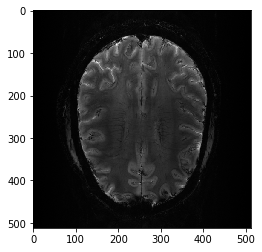

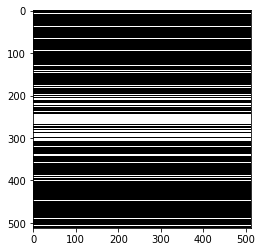

In [9]:
image = get_sample_data('2d-mri')
mask = get_sample_data("cartesian-mri-mask")
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------
From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [10]:
kspace_loc = convert_mask_to_locations(mask.data)
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

Zero Filled solution

Text(0.5, 1.0, 'Zero Order Solution\nSSIM = 0.8227803311638904')

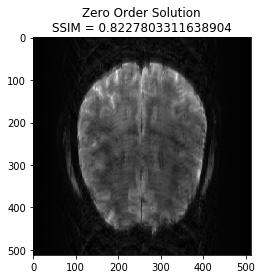

In [11]:
image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data),
                         metadata=image.metadata)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()

Setup Reconstruction Operators
------------------------------

Linear Operator : Symlet8 with 4 Scales

In [12]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)

Regularizer Operator : SparseThreshold ie L1 Norm. Lambda = 2e-7

In [13]:
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

Setup Single Channel Reconstructor

In [14]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000000552
The lipschitz constraint is satisfied


FISTA optimization
------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost
Start Reconstruction

 - mu:  2e-07
 - lipschitz constant:  1.1000000000000552
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7ffa42167358> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...
 - final iteration number:  400
 - final log10 cost value:  -7.835135817192753
 - converged:  True
Done.
Execution time:  76.47286900000002  seconds
----------------------------------------


100% (200 of 200) |######################| Elapsed Time: 0:00:52 Time:  0:00:52


Text(0.5, 1.0, 'FISTA Reconstruction\nSSIM = 0.924618392073577')

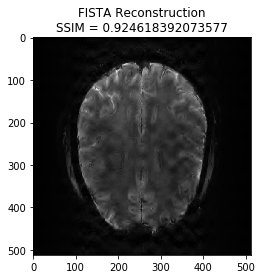

In [16]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()